# Modeul Import & 환경 설정

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import random
import os

from sklearn.model_selection import train_test_split
from supervised.automl import AutoML

C:\Users\NEXEN\anaconda3\envs\py38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# GPU 구동 확인
import tensorflow as tf

# GPU 정보 출력
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("GPU 사용 불가능")
else:
    print("사용 가능한 GPU 개수:", len(physical_devices))
    for device in physical_devices:
        print("GPU 이름:", device.name)

사용 가능한 GPU 개수: 1
GPU 이름: /physical_device:GPU:0


In [3]:
# 경고 문구 무시
warnings.filterwarnings(action='ignore') 

In [4]:
# 그래프 폰트 설정
plt.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.unicode_minus'] = False

In [5]:
# Seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

# CSV file Load

In [6]:
adult_train_csv = pd.read_csv('./dataset/ECG_adult_age_train.csv')
child_train_csv = pd.read_csv('./dataset/ECG_child_age_train.csv')

In [7]:
adult_train_csv.info()
adult_train_csv.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34907 entries, 0 to 34906
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FILENAME  34907 non-null  object
 1   GENDER    34907 non-null  object
 2   AGE       34907 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 818.3+ KB


,FILENAME,GENDER,AGE
0,ecg_adult_0,MALE,53
1,ecg_adult_1,MALE,68
2,ecg_adult_2,MALE,68
3,ecg_adult_3,MALE,89
4,ecg_adult_4,MALE,79
5,ecg_adult_5,FEMALE,59
6,ecg_adult_6,MALE,79
7,ecg_adult_7,MALE,83
8,ecg_adult_8,MALE,86
9,ecg_adult_9,FEMALE,65


In [8]:
child_train_csv.info()
child_train_csv.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8781 entries, 0 to 8780
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FILENAME  8781 non-null   object 
 1   GENDER    8781 non-null   object 
 2   AGE       8781 non-null   float64
dtypes: float64(1), object(2)
memory usage: 205.9+ KB


,FILENAME,GENDER,AGE
0,ecg_child_0,MALE,1.500000
1,ecg_child_1,MALE,4.833333
2,ecg_child_2,FEMALE,5.583333
3,ecg_child_3,FEMALE,5.083333
4,ecg_child_4,MALE,0.166667
5,ecg_child_5,FEMALE,0.750000
6,ecg_child_6,MALE,0.333333
7,ecg_child_7,MALE,1.583333
8,ecg_child_8,FEMALE,6.166667
9,ecg_child_9,MALE,0.500000


## 결측치 & 이상치 확인

In [9]:
# adult - 성별 칼럼 값 확인
adult_train_csv['GENDER'].value_counts()

FEMALE     18096
MALE       16787
unknown       24
Name: GENDER, dtype: int64

In [10]:
# child - 성별 칼럼 값 확인
child_train_csv['GENDER'].value_counts()

MALE       4854
FEMALE     3926
unknown       1
Name: GENDER, dtype: int64

In [11]:
# adult - 나이 칼럼 값 확인
adult_train_csv['AGE'].value_counts().sort_index()

19     126
20     102
21     141
22     179
23     168
      ... 
99       5
100      2
101      4
104      1
122      4
Name: AGE, Length: 85, dtype: int64

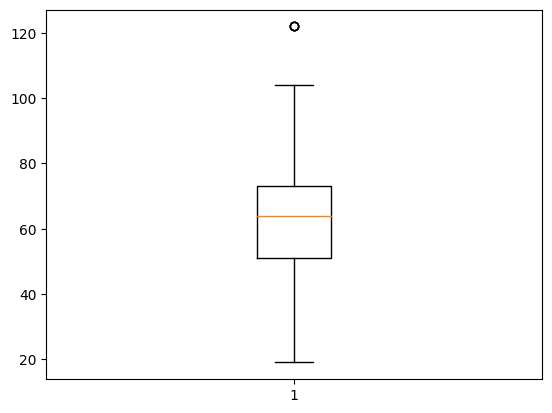

In [12]:
plt.boxplot(adult_train_csv['AGE'])
plt.show()

In [13]:
# child - 나이 칼럼 값 확인
child_train_csv['AGE'].value_counts().sort_index()

0.083333    380
0.166667    242
0.250000    264
0.333333    339
0.416667    332
           ... 
7.416667      2
7.666667      1
7.750000      1
7.916667      3
8.083333      2
Name: AGE, Length: 93, dtype: int64

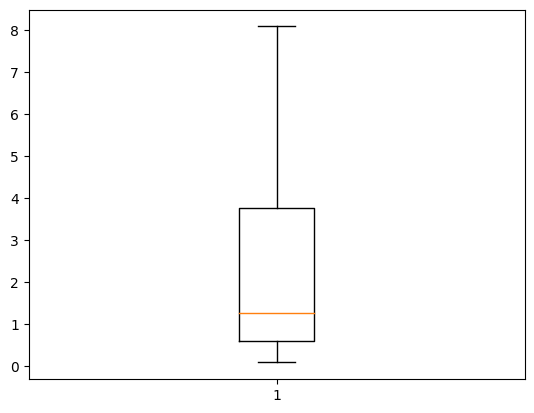

In [14]:
plt.boxplot(child_train_csv['AGE'])
plt.show()

- Submission 파일에도 성별이 unknown인 경우가 있으므로 삭제 X


- 나이도 100세 이상 데이터가 보이지만 불가능한 데이터가 아니므로 삭제 X

# Data Preprocessing

- 제공받은 npy 데이터는 60000x1 형태이지만 실제로는 5000x12 형태를 의미함


- Squeeze된 데이터를 전처리를 통해 분리할 필요 O

In [15]:
# ECG data sample 불러오기
sample = np.load('./dataset/ECG_adult_numpy_train/ecg_adult_0.npy')
sample

array([ 12. ,  12. ,  12. , ..., -20. , -18.5, -17. ])

In [16]:
sample.shape

(60000,)

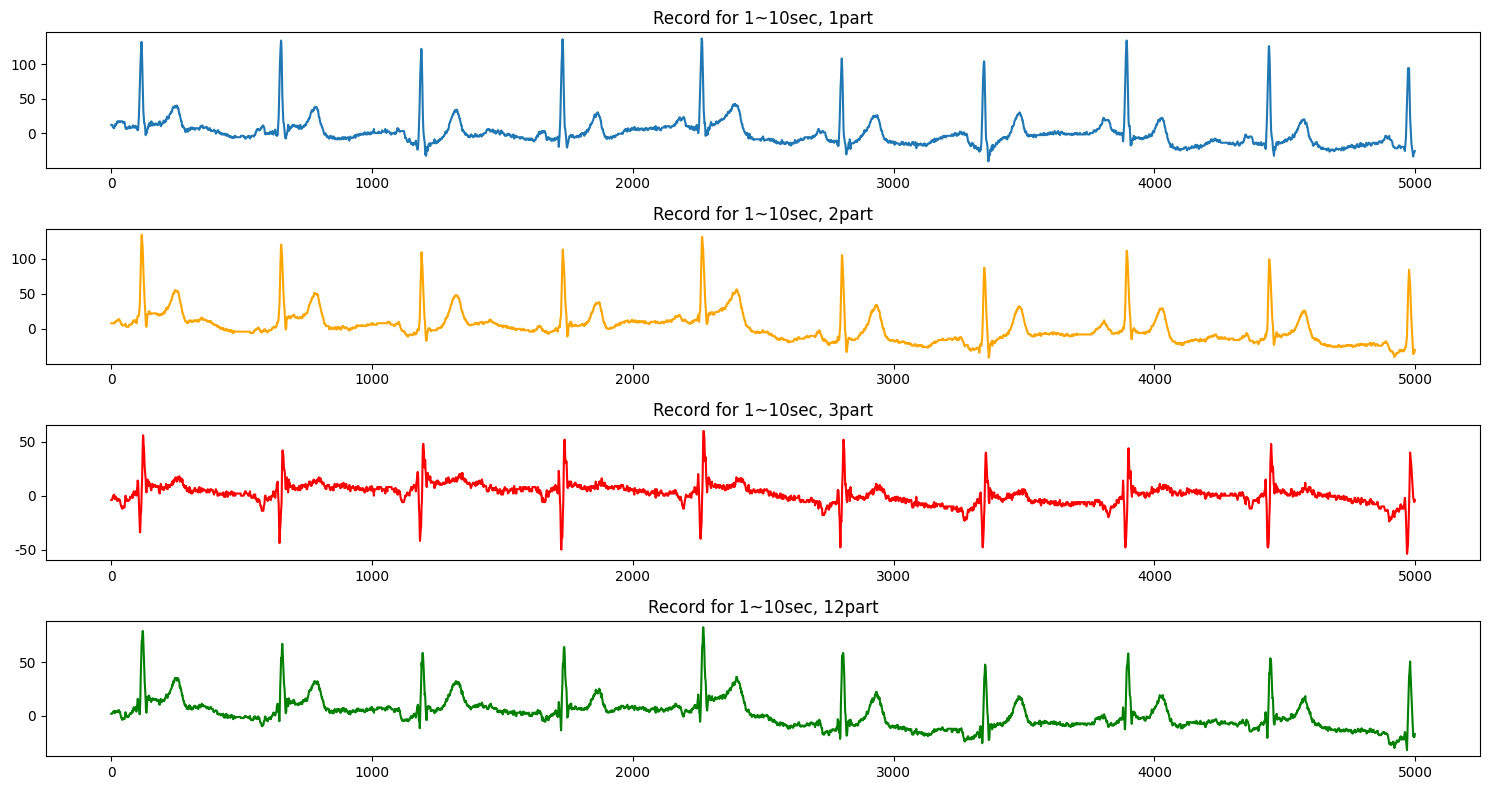

In [17]:
plt.figure(figsize=(15,8))
plt.subplot(4,1,1)
plt.plot(sample[0:5000])
plt.title('Record for 1~10sec, 1part')

plt.subplot(4,1,2)
plt.plot(sample[5000:10000], 'orange')
plt.title('Record for 1~10sec, 2part')

plt.subplot(4,1,3)
plt.plot(sample[10000:15000], 'r')
plt.title('Record for 1~10sec, 3part')

plt.subplot(4,1,4)
plt.plot(sample[55000:60000], 'g')
plt.title('Record for 1~10sec, 12part')

plt.tight_layout()
plt.show()

In [18]:
# 데이터 전처리 함수 정의
def ECG_prep(data):
    ECG_avg_min_max = [] # 측정값을 저장할 리스트 정의
    
    for i in np.arange(0,len(data),5000):
        ECG_avg = data[i:i+5000].mean() # 5000개 평균 계산
        ECG_min = data[i:i+5000].min() # 5000개 최솟값 계산
        ECG_max = data[i:i+5000].max() # 5000개 최댓값 계산
        
        # 순서대로 리스트에 저장
        ECG_avg_min_max.append(ECG_avg)
        ECG_avg_min_max.append(ECG_min)
        ECG_avg_min_max.append(ECG_max)
    
    return ECG_avg_min_max    

# 학습용 Dataset 구성

## 부위별 평균치 데이터 프레임 생성

In [19]:
# 데아터셋 경로 설정
adult_train_path = './dataset/ECG_adult_numpy_train/'
adult_valid_path = './dataset/ECG_adult_numpy_valid/'
child_train_path = './dataset/ECG_child_numpy_train/'
child_valid_path = './dataset/ECG_child_numpy_valid//'

In [20]:
# 칼럼 생성
places = ['I', 'II', 'III', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'aVR', 'aVL', 'aVF']
stats = ['AVG', 'MIN', 'MAX']
ECG_columns = []

for place in places:
    for stat in stats:
        part = place + '_' + stat
        ECG_columns.append(part)
        
ECG_columns

['I_AVG',
 'I_MIN',
 'I_MAX',
 'II_AVG',
 'II_MIN',
 'II_MAX',
 'III_AVG',
 'III_MIN',
 'III_MAX',
 'V1_AVG',
 'V1_MIN',
 'V1_MAX',
 'V2_AVG',
 'V2_MIN',
 'V2_MAX',
 'V3_AVG',
 'V3_MIN',
 'V3_MAX',
 'V4_AVG',
 'V4_MIN',
 'V4_MAX',
 'V5_AVG',
 'V5_MIN',
 'V5_MAX',
 'V6_AVG',
 'V6_MIN',
 'V6_MAX',
 'aVR_AVG',
 'aVR_MIN',
 'aVR_MAX',
 'aVL_AVG',
 'aVL_MIN',
 'aVL_MAX',
 'aVF_AVG',
 'aVF_MIN',
 'aVF_MAX']

In [21]:
adult_train_list = [] # adult용 학습데이터 저장용 리스트

for npy_file in adult_train_csv['FILENAME']:
    file = np.load(adult_train_path + npy_file + '.npy')
    ECG_value = ECG_prep(file)
    adult_train_list.append(ECG_value)

In [22]:
len(adult_train_list)

34907

In [23]:
adult_train_df = pd.DataFrame(np.array(adult_train_list), columns=ECG_columns)
adult_train_df

,I_AVG,I_MIN,I_MAX,II_AVG,II_MIN,II_MAX,III_AVG,III_MIN,III_MAX,V1_AVG,...,V6_MAX,aVR_AVG,aVR_MIN,aVR_MAX,aVL_AVG,aVL_MIN,aVL_MAX,aVF_AVG,aVF_MIN,aVF_MAX
0,0.4130,-41.0,137.0,2.0298,-41.0,134.0,1.6168,-54.0,60.0,-3.4768,...,240.0,-1.2214,-131.5,39.0,-0.6019,-32.0,86.5,1.8233,-32.0,83.0
1,-3.7996,-74.0,120.0,-3.9202,-59.0,140.0,-0.1206,-26.0,116.0,-1.4362,...,340.0,3.8599,-124.5,53.0,-1.8395,-89.5,61.5,-2.0204,-36.5,94.5
2,2.3400,-36.0,120.0,4.1626,-24.0,76.0,1.8226,-58.0,48.0,5.5376,...,272.0,-3.2513,-97.0,17.0,0.2587,-42.0,88.0,2.9926,-25.0,46.0
3,4.9236,-39.0,205.0,-4.7878,-97.0,151.0,-9.7114,-134.0,40.0,-14.2506,...,614.0,-0.0679,-165.0,46.0,7.3175,-28.5,156.5,-7.2496,-99.5,64.0
4,-0.1024,-97.0,213.0,-3.2966,-104.0,72.0,-3.1942,-255.0,71.0,-7.3658,...,580.0,1.6995,-135.5,74.0,1.5459,-79.0,223.5,-3.2454,-171.0,29.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34902,-0.0440,-61.0,114.0,-10.0902,-92.0,259.0,-10.0462,-88.0,202.0,-3.4496,...,269.0,5.0671,-168.0,51.0,5.0011,-78.5,70.5,-10.0682,-90.0,228.5
34903,4.5834,-68.0,92.0,0.9478,-77.0,52.0,-3.6356,-116.0,72.0,-4.3614,...,230.0,-2.7656,-64.0,55.5,4.1095,-64.5,98.0,-1.3439,-96.5,50.0
34904,-0.2576,-44.0,147.0,0.0466,-62.0,226.0,0.3042,-37.0,128.0,-4.6558,...,290.0,0.1055,-180.5,49.0,-0.2809,-27.0,56.5,0.1754,-49.5,177.0
34905,4.6174,-128.0,118.0,-3.4308,-104.0,191.0,-8.0482,-70.0,227.0,-2.3102,...,631.0,-0.5933,-141.5,108.0,6.3328,-150.5,68.0,-5.7395,-55.0,200.5


In [24]:
child_train_list = [] # child용 학습데이터 저장용 리스트

for npy_file in child_train_csv['FILENAME']:
    file = np.load(child_train_path + npy_file + '.npy')
    ECG_value = ECG_prep(file)
    child_train_list.append(ECG_value)

In [25]:
len(child_train_list)

8781

In [26]:
child_train_df = pd.DataFrame(np.array(child_train_list), columns=ECG_columns)
child_train_df

,I_AVG,I_MIN,I_MAX,II_AVG,II_MIN,II_MAX,III_AVG,III_MIN,III_MAX,V1_AVG,...,V6_MAX,aVR_AVG,aVR_MIN,aVR_MAX,aVL_AVG,aVL_MIN,aVL_MAX,aVF_AVG,aVF_MIN,aVF_MAX
0,-2.8170,-270.0,99.0,1.0062,-117.0,181.0,3.8232,-79.0,217.0,0.1218,...,343.0,0.9054,-134.0,176.5,-3.3201,-240.0,75.0,2.4147,-51.5,167.0
1,-1.8126,-32.0,168.0,1.2598,-21.0,94.0,3.0724,-101.0,69.0,-1.7206,...,193.0,0.2764,-127.0,19.5,-2.4425,-48.5,131.0,2.1661,-24.5,55.0
2,-2.9676,-38.0,307.0,-2.6282,-30.0,149.0,0.3394,-220.0,39.0,-1.8582,...,453.0,2.7979,-208.0,30.0,-1.6535,-35.5,259.5,-1.1444,-72.0,60.5
3,1.0040,-37.0,274.0,-2.8564,-35.0,129.0,-3.8604,-162.0,39.0,0.0602,...,165.0,0.9262,-194.5,32.5,2.4322,-29.5,218.0,-3.3584,-33.5,30.0
4,0.2146,-69.0,233.0,-5.3810,-136.0,177.0,-5.5956,-169.0,136.0,-12.4928,...,364.0,2.5832,-190.5,87.0,2.9051,-100.0,193.0,-5.4883,-117.0,115.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8776,1.8742,-118.0,253.0,-5.9838,-156.0,375.0,-7.8580,-260.0,199.0,-3.1612,...,253.0,2.0548,-276.0,119.0,4.8661,-94.0,233.0,-6.9209,-169.0,286.5
8777,0.9678,-355.0,224.0,-3.5320,-371.0,170.0,-4.4998,-301.0,140.0,-10.9560,...,306.0,1.2821,-156.5,320.0,2.7338,-216.5,235.5,-4.0159,-298.0,120.0
8778,-2.6432,-46.0,191.0,-4.1144,-48.0,160.0,-1.4712,-113.0,27.0,-2.7378,...,319.0,3.3788,-157.0,44.5,-0.5860,-24.5,144.5,-2.7928,-41.5,83.0
8779,0.4514,-35.0,58.0,-17.6834,-104.0,270.0,-18.1348,-84.0,264.0,0.1082,...,295.0,8.6160,-151.0,68.0,9.2931,-129.0,39.5,-17.9091,-90.0,267.0


## 기존 CSV 데이터와 병합

In [27]:
# adult train 데이터셋 생성
adult_train_dataset = pd.concat([adult_train_csv, adult_train_df], axis=1)
adult_train_dataset

,FILENAME,GENDER,AGE,I_AVG,I_MIN,I_MAX,II_AVG,II_MIN,II_MAX,III_AVG,...,V6_MAX,aVR_AVG,aVR_MIN,aVR_MAX,aVL_AVG,aVL_MIN,aVL_MAX,aVF_AVG,aVF_MIN,aVF_MAX
0,ecg_adult_0,MALE,53,0.4130,-41.0,137.0,2.0298,-41.0,134.0,1.6168,...,240.0,-1.2214,-131.5,39.0,-0.6019,-32.0,86.5,1.8233,-32.0,83.0
1,ecg_adult_1,MALE,68,-3.7996,-74.0,120.0,-3.9202,-59.0,140.0,-0.1206,...,340.0,3.8599,-124.5,53.0,-1.8395,-89.5,61.5,-2.0204,-36.5,94.5
2,ecg_adult_2,MALE,68,2.3400,-36.0,120.0,4.1626,-24.0,76.0,1.8226,...,272.0,-3.2513,-97.0,17.0,0.2587,-42.0,88.0,2.9926,-25.0,46.0
3,ecg_adult_3,MALE,89,4.9236,-39.0,205.0,-4.7878,-97.0,151.0,-9.7114,...,614.0,-0.0679,-165.0,46.0,7.3175,-28.5,156.5,-7.2496,-99.5,64.0
4,ecg_adult_4,MALE,79,-0.1024,-97.0,213.0,-3.2966,-104.0,72.0,-3.1942,...,580.0,1.6995,-135.5,74.0,1.5459,-79.0,223.5,-3.2454,-171.0,29.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34902,ecg_adult_35136,MALE,19,-0.0440,-61.0,114.0,-10.0902,-92.0,259.0,-10.0462,...,269.0,5.0671,-168.0,51.0,5.0011,-78.5,70.5,-10.0682,-90.0,228.5
34903,ecg_adult_35137,FEMALE,63,4.5834,-68.0,92.0,0.9478,-77.0,52.0,-3.6356,...,230.0,-2.7656,-64.0,55.5,4.1095,-64.5,98.0,-1.3439,-96.5,50.0
34904,ecg_adult_35138,MALE,60,-0.2576,-44.0,147.0,0.0466,-62.0,226.0,0.3042,...,290.0,0.1055,-180.5,49.0,-0.2809,-27.0,56.5,0.1754,-49.5,177.0
34905,ecg_adult_35139,FEMALE,60,4.6174,-128.0,118.0,-3.4308,-104.0,191.0,-8.0482,...,631.0,-0.5933,-141.5,108.0,6.3328,-150.5,68.0,-5.7395,-55.0,200.5


In [28]:
# child train 데이터셋 생성
child_train_dataset = pd.concat([child_train_csv, child_train_df], axis=1)
child_train_dataset

,FILENAME,GENDER,AGE,I_AVG,I_MIN,I_MAX,II_AVG,II_MIN,II_MAX,III_AVG,...,V6_MAX,aVR_AVG,aVR_MIN,aVR_MAX,aVL_AVG,aVL_MIN,aVL_MAX,aVF_AVG,aVF_MIN,aVF_MAX
0,ecg_child_0,MALE,1.500000,-2.8170,-270.0,99.0,1.0062,-117.0,181.0,3.8232,...,343.0,0.9054,-134.0,176.5,-3.3201,-240.0,75.0,2.4147,-51.5,167.0
1,ecg_child_1,MALE,4.833333,-1.8126,-32.0,168.0,1.2598,-21.0,94.0,3.0724,...,193.0,0.2764,-127.0,19.5,-2.4425,-48.5,131.0,2.1661,-24.5,55.0
2,ecg_child_2,FEMALE,5.583333,-2.9676,-38.0,307.0,-2.6282,-30.0,149.0,0.3394,...,453.0,2.7979,-208.0,30.0,-1.6535,-35.5,259.5,-1.1444,-72.0,60.5
3,ecg_child_3,FEMALE,5.083333,1.0040,-37.0,274.0,-2.8564,-35.0,129.0,-3.8604,...,165.0,0.9262,-194.5,32.5,2.4322,-29.5,218.0,-3.3584,-33.5,30.0
4,ecg_child_4,MALE,0.166667,0.2146,-69.0,233.0,-5.3810,-136.0,177.0,-5.5956,...,364.0,2.5832,-190.5,87.0,2.9051,-100.0,193.0,-5.4883,-117.0,115.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8776,ecg_child_8776,MALE,0.666667,1.8742,-118.0,253.0,-5.9838,-156.0,375.0,-7.8580,...,253.0,2.0548,-276.0,119.0,4.8661,-94.0,233.0,-6.9209,-169.0,286.5
8777,ecg_child_8777,MALE,0.083333,0.9678,-355.0,224.0,-3.5320,-371.0,170.0,-4.4998,...,306.0,1.2821,-156.5,320.0,2.7338,-216.5,235.5,-4.0159,-298.0,120.0
8778,ecg_child_8778,FEMALE,5.833333,-2.6432,-46.0,191.0,-4.1144,-48.0,160.0,-1.4712,...,319.0,3.3788,-157.0,44.5,-0.5860,-24.5,144.5,-2.7928,-41.5,83.0
8779,ecg_child_8779,FEMALE,2.250000,0.4514,-35.0,58.0,-17.6834,-104.0,270.0,-18.1348,...,295.0,8.6160,-151.0,68.0,9.2931,-129.0,39.5,-17.9091,-90.0,267.0


In [29]:
# GENDER 변수 One-Hot encoding
adult_train_dataset = pd.get_dummies(adult_train_dataset, columns = ['GENDER'], dtype='int64')
child_train_dataset = pd.get_dummies(child_train_dataset, columns = ['GENDER'], dtype='int64')

In [30]:
adult_train_dataset

,FILENAME,AGE,I_AVG,I_MIN,I_MAX,II_AVG,II_MIN,II_MAX,III_AVG,III_MIN,...,aVR_MAX,aVL_AVG,aVL_MIN,aVL_MAX,aVF_AVG,aVF_MIN,aVF_MAX,GENDER_FEMALE,GENDER_MALE,GENDER_unknown
0,ecg_adult_0,53,0.4130,-41.0,137.0,2.0298,-41.0,134.0,1.6168,-54.0,...,39.0,-0.6019,-32.0,86.5,1.8233,-32.0,83.0,0,1,0
1,ecg_adult_1,68,-3.7996,-74.0,120.0,-3.9202,-59.0,140.0,-0.1206,-26.0,...,53.0,-1.8395,-89.5,61.5,-2.0204,-36.5,94.5,0,1,0
2,ecg_adult_2,68,2.3400,-36.0,120.0,4.1626,-24.0,76.0,1.8226,-58.0,...,17.0,0.2587,-42.0,88.0,2.9926,-25.0,46.0,0,1,0
3,ecg_adult_3,89,4.9236,-39.0,205.0,-4.7878,-97.0,151.0,-9.7114,-134.0,...,46.0,7.3175,-28.5,156.5,-7.2496,-99.5,64.0,0,1,0
4,ecg_adult_4,79,-0.1024,-97.0,213.0,-3.2966,-104.0,72.0,-3.1942,-255.0,...,74.0,1.5459,-79.0,223.5,-3.2454,-171.0,29.5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34902,ecg_adult_35136,19,-0.0440,-61.0,114.0,-10.0902,-92.0,259.0,-10.0462,-88.0,...,51.0,5.0011,-78.5,70.5,-10.0682,-90.0,228.5,0,1,0
34903,ecg_adult_35137,63,4.5834,-68.0,92.0,0.9478,-77.0,52.0,-3.6356,-116.0,...,55.5,4.1095,-64.5,98.0,-1.3439,-96.5,50.0,1,0,0
34904,ecg_adult_35138,60,-0.2576,-44.0,147.0,0.0466,-62.0,226.0,0.3042,-37.0,...,49.0,-0.2809,-27.0,56.5,0.1754,-49.5,177.0,0,1,0
34905,ecg_adult_35139,60,4.6174,-128.0,118.0,-3.4308,-104.0,191.0,-8.0482,-70.0,...,108.0,6.3328,-150.5,68.0,-5.7395,-55.0,200.5,1,0,0


In [31]:
child_train_dataset

,FILENAME,AGE,I_AVG,I_MIN,I_MAX,II_AVG,II_MIN,II_MAX,III_AVG,III_MIN,...,aVR_MAX,aVL_AVG,aVL_MIN,aVL_MAX,aVF_AVG,aVF_MIN,aVF_MAX,GENDER_FEMALE,GENDER_MALE,GENDER_unknown
0,ecg_child_0,1.500000,-2.8170,-270.0,99.0,1.0062,-117.0,181.0,3.8232,-79.0,...,176.5,-3.3201,-240.0,75.0,2.4147,-51.5,167.0,0,1,0
1,ecg_child_1,4.833333,-1.8126,-32.0,168.0,1.2598,-21.0,94.0,3.0724,-101.0,...,19.5,-2.4425,-48.5,131.0,2.1661,-24.5,55.0,0,1,0
2,ecg_child_2,5.583333,-2.9676,-38.0,307.0,-2.6282,-30.0,149.0,0.3394,-220.0,...,30.0,-1.6535,-35.5,259.5,-1.1444,-72.0,60.5,1,0,0
3,ecg_child_3,5.083333,1.0040,-37.0,274.0,-2.8564,-35.0,129.0,-3.8604,-162.0,...,32.5,2.4322,-29.5,218.0,-3.3584,-33.5,30.0,1,0,0
4,ecg_child_4,0.166667,0.2146,-69.0,233.0,-5.3810,-136.0,177.0,-5.5956,-169.0,...,87.0,2.9051,-100.0,193.0,-5.4883,-117.0,115.5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8776,ecg_child_8776,0.666667,1.8742,-118.0,253.0,-5.9838,-156.0,375.0,-7.8580,-260.0,...,119.0,4.8661,-94.0,233.0,-6.9209,-169.0,286.5,0,1,0
8777,ecg_child_8777,0.083333,0.9678,-355.0,224.0,-3.5320,-371.0,170.0,-4.4998,-301.0,...,320.0,2.7338,-216.5,235.5,-4.0159,-298.0,120.0,0,1,0
8778,ecg_child_8778,5.833333,-2.6432,-46.0,191.0,-4.1144,-48.0,160.0,-1.4712,-113.0,...,44.5,-0.5860,-24.5,144.5,-2.7928,-41.5,83.0,1,0,0
8779,ecg_child_8779,2.250000,0.4514,-35.0,58.0,-17.6834,-104.0,270.0,-18.1348,-84.0,...,68.0,9.2931,-129.0,39.5,-17.9091,-90.0,267.0,1,0,0


# Modeling

## Adult Model

In [33]:
# 학습 및 검증용 데이터 분할
adult_X = adult_train_dataset.drop(['FILENAME', 'AGE'], axis=1)
adult_X

,I_AVG,I_MIN,I_MAX,II_AVG,II_MIN,II_MAX,III_AVG,III_MIN,III_MAX,V1_AVG,...,aVR_MAX,aVL_AVG,aVL_MIN,aVL_MAX,aVF_AVG,aVF_MIN,aVF_MAX,GENDER_FEMALE,GENDER_MALE,GENDER_unknown
0,0.4130,-41.0,137.0,2.0298,-41.0,134.0,1.6168,-54.0,60.0,-3.4768,...,39.0,-0.6019,-32.0,86.5,1.8233,-32.0,83.0,0,1,0
1,-3.7996,-74.0,120.0,-3.9202,-59.0,140.0,-0.1206,-26.0,116.0,-1.4362,...,53.0,-1.8395,-89.5,61.5,-2.0204,-36.5,94.5,0,1,0
2,2.3400,-36.0,120.0,4.1626,-24.0,76.0,1.8226,-58.0,48.0,5.5376,...,17.0,0.2587,-42.0,88.0,2.9926,-25.0,46.0,0,1,0
3,4.9236,-39.0,205.0,-4.7878,-97.0,151.0,-9.7114,-134.0,40.0,-14.2506,...,46.0,7.3175,-28.5,156.5,-7.2496,-99.5,64.0,0,1,0
4,-0.1024,-97.0,213.0,-3.2966,-104.0,72.0,-3.1942,-255.0,71.0,-7.3658,...,74.0,1.5459,-79.0,223.5,-3.2454,-171.0,29.5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34902,-0.0440,-61.0,114.0,-10.0902,-92.0,259.0,-10.0462,-88.0,202.0,-3.4496,...,51.0,5.0011,-78.5,70.5,-10.0682,-90.0,228.5,0,1,0
34903,4.5834,-68.0,92.0,0.9478,-77.0,52.0,-3.6356,-116.0,72.0,-4.3614,...,55.5,4.1095,-64.5,98.0,-1.3439,-96.5,50.0,1,0,0
34904,-0.2576,-44.0,147.0,0.0466,-62.0,226.0,0.3042,-37.0,128.0,-4.6558,...,49.0,-0.2809,-27.0,56.5,0.1754,-49.5,177.0,0,1,0
34905,4.6174,-128.0,118.0,-3.4308,-104.0,191.0,-8.0482,-70.0,227.0,-2.3102,...,108.0,6.3328,-150.5,68.0,-5.7395,-55.0,200.5,1,0,0


In [35]:
adult_y = adult_train_dataset['AGE']
adult_y

0        53
1        68
2        68
3        89
4        79
         ..
34902    19
34903    63
34904    60
34905    60
34906    53
Name: AGE, Length: 34907, dtype: int64

In [48]:
# AutoML 수행
adult_model = AutoML(mode='Compete', 
               ml_task='regression', 
               eval_metric='mae', 
               random_state=42, 
               total_time_limit=3600*6)
adult_model.fit(adult_X, adult_y)

Linear algorithm was disabled.
AutoML directory: AutoML_2
The task is regression with evaluation metric mae
AutoML will use algorithms: ['Decision Tree', 'Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network', 'Nearest Neighbors']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step adjust_validation will try to check up to 1 model
1_DecisionTree mae 12.032508 trained in 0.64 seconds
Adjust validation. Remove: 1_DecisionTree
Validation strategy: 10-fold CV Shuffle
* Step simple_algorithms will try to check up to 3 models
1_DecisionTree mae 11.909537 trained in 5.64 seconds
2_DecisionTree mae 12.354598 trained in 4.23 seconds
3_DecisionTree mae 12.354598 trained in 4.

83_NeuralNetwork_SelectedFeatures mae 10.301983 trained in 20.84 seconds
84_RandomForest mae 11.297128 trained in 40.71 seconds
85_RandomForest mae 11.294912 trained in 56.39 seconds
86_RandomForest_SelectedFeatures mae 11.298126 trained in 52.42 seconds
87_RandomForest_SelectedFeatures mae 11.295185 trained in 51.37 seconds
88_RandomForest mae 11.301931 trained in 53.44 seconds
89_ExtraTrees mae 11.59492 trained in 23.89 seconds
90_ExtraTrees mae 11.55473 trained in 25.83 seconds
91_ExtraTrees_SelectedFeatures mae 11.615791 trained in 26.18 seconds
92_ExtraTrees_SelectedFeatures mae 11.557148 trained in 25.78 seconds
93_ExtraTrees mae 11.638011 trained in 18.82 seconds
94_DecisionTree mae 12.106906 trained in 12.83 seconds
95_DecisionTree mae 12.106906 trained in 12.89 seconds
96_DecisionTree mae 12.106906 trained in 12.98 seconds
* Step hill_climbing_2 will try to check up to 29 models
97_CatBoost_GoldenFeatures mae 10.225421 trained in 132.77 seconds
98_CatBoost_GoldenFeatures_Selec

AutoML(eval_metric='mae', ml_task='regression', mode='Compete', random_state=42,
       total_time_limit=21600)

## Child Model

In [49]:
# 학습 및 검증용 데이터 분할
child_X = child_train_dataset.drop(['FILENAME', 'AGE'], axis=1)
child_X

,I_AVG,I_MIN,I_MAX,II_AVG,II_MIN,II_MAX,III_AVG,III_MIN,III_MAX,V1_AVG,...,aVR_MAX,aVL_AVG,aVL_MIN,aVL_MAX,aVF_AVG,aVF_MIN,aVF_MAX,GENDER_FEMALE,GENDER_MALE,GENDER_unknown
0,-2.8170,-270.0,99.0,1.0062,-117.0,181.0,3.8232,-79.0,217.0,0.1218,...,176.5,-3.3201,-240.0,75.0,2.4147,-51.5,167.0,0,1,0
1,-1.8126,-32.0,168.0,1.2598,-21.0,94.0,3.0724,-101.0,69.0,-1.7206,...,19.5,-2.4425,-48.5,131.0,2.1661,-24.5,55.0,0,1,0
2,-2.9676,-38.0,307.0,-2.6282,-30.0,149.0,0.3394,-220.0,39.0,-1.8582,...,30.0,-1.6535,-35.5,259.5,-1.1444,-72.0,60.5,1,0,0
3,1.0040,-37.0,274.0,-2.8564,-35.0,129.0,-3.8604,-162.0,39.0,0.0602,...,32.5,2.4322,-29.5,218.0,-3.3584,-33.5,30.0,1,0,0
4,0.2146,-69.0,233.0,-5.3810,-136.0,177.0,-5.5956,-169.0,136.0,-12.4928,...,87.0,2.9051,-100.0,193.0,-5.4883,-117.0,115.5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8776,1.8742,-118.0,253.0,-5.9838,-156.0,375.0,-7.8580,-260.0,199.0,-3.1612,...,119.0,4.8661,-94.0,233.0,-6.9209,-169.0,286.5,0,1,0
8777,0.9678,-355.0,224.0,-3.5320,-371.0,170.0,-4.4998,-301.0,140.0,-10.9560,...,320.0,2.7338,-216.5,235.5,-4.0159,-298.0,120.0,0,1,0
8778,-2.6432,-46.0,191.0,-4.1144,-48.0,160.0,-1.4712,-113.0,27.0,-2.7378,...,44.5,-0.5860,-24.5,144.5,-2.7928,-41.5,83.0,1,0,0
8779,0.4514,-35.0,58.0,-17.6834,-104.0,270.0,-18.1348,-84.0,264.0,0.1082,...,68.0,9.2931,-129.0,39.5,-17.9091,-90.0,267.0,1,0,0


In [50]:
child_y = child_train_dataset['AGE']
child_y

0       1.500000
1       4.833333
2       5.583333
3       5.083333
4       0.166667
          ...   
8776    0.666667
8777    0.083333
8778    5.833333
8779    2.250000
8780    4.500000
Name: AGE, Length: 8781, dtype: float64

In [51]:
# AutoML 수행
child_model = AutoML(mode='Compete', 
               ml_task='regression', 
               eval_metric='mae', 
               random_state=42, 
               total_time_limit=3600*6)
child_model.fit(child_X, child_y)

AutoML directory: AutoML_3
The task is regression with evaluation metric mae
AutoML will use algorithms: ['Decision Tree', 'Linear', 'Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network', 'Nearest Neighbors']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step adjust_validation will try to check up to 1 model
1_DecisionTree mae 0.9437 trained in 3.75 seconds
Adjust validation. Remove: 1_DecisionTree
Validation strategy: 10-fold CV Shuffle
* Step simple_algorithms will try to check up to 4 models
1_DecisionTree mae 0.937673 trained in 20.53 seconds
2_DecisionTree mae 1.039757 trained in 18.45 seconds
3_DecisionTree mae 1.039757 trained in 18.81 seconds
4_Linear mae 

86_ExtraTrees mae 0.900391 trained in 33.62 seconds
87_ExtraTrees_SelectedFeatures mae 1.003334 trained in 33.73 seconds
88_ExtraTrees_SelectedFeatures mae 0.914324 trained in 34.93 seconds
89_ExtraTrees mae 1.04463 trained in 32.38 seconds
90_ExtraTrees mae 0.94374 trained in 35.48 seconds
91_DecisionTree mae 0.97432 trained in 28.57 seconds
92_DecisionTree mae 0.97432 trained in 28.85 seconds
* Step hill_climbing_2 will try to check up to 29 models
93_CatBoost_GoldenFeatures mae 0.710332 trained in 131.94 seconds
94_CatBoost mae 0.713446 trained in 57.44 seconds
95_CatBoost_GoldenFeatures mae 0.708221 trained in 51.64 seconds
96_LightGBM mae 0.744168 trained in 32.8 seconds
97_LightGBM mae 0.742457 trained in 33.87 seconds
98_LightGBM mae 0.743477 trained in 34.21 seconds
99_LightGBM mae 0.739257 trained in 34.13 seconds
100_LightGBM mae 0.746535 trained in 32.26 seconds
101_LightGBM mae 0.746368 trained in 31.63 seconds
102_Xgboost mae 0.749787 trained in 36.43 seconds
103_Xgboost m

AutoML(eval_metric='mae', ml_task='regression', mode='Compete', random_state=42,
       total_time_limit=21600)

# Forecasting

In [52]:
submission = pd.read_csv('./dataset/submission.csv')
submission

,FILENAME,GENDER,AGE
0,ecg_child_8781,FEMALE,NaN
1,ecg_child_8782,MALE,NaN
2,ecg_child_8783,MALE,NaN
3,ecg_child_8784,FEMALE,NaN
4,ecg_child_8785,FEMALE,NaN
...,...,...,...
5470,ecg_adult_39536,FEMALE,NaN
5471,ecg_adult_39537,FEMALE,NaN
5472,ecg_adult_39538,FEMALE,NaN
5473,ecg_adult_39539,FEMALE,NaN


## Adult data

In [53]:
adult_valid_list = [] # adult용 검증 데이터 저장용 리스트

for npy_file in submission['FILENAME'][1100:]:
    file = np.load(adult_valid_path + npy_file + '.npy')
    ECG_value = ECG_prep(file)
    adult_valid_list.append(ECG_value)

In [54]:
adult_valid_df = pd.DataFrame(np.array(adult_valid_list), columns=ECG_columns)
adult_valid_df

,I_AVG,I_MIN,I_MAX,II_AVG,II_MIN,II_MAX,III_AVG,III_MIN,III_MAX,V1_AVG,...,V6_MAX,aVR_AVG,aVR_MIN,aVR_MAX,aVL_AVG,aVL_MIN,aVL_MAX,aVF_AVG,aVF_MIN,aVF_MAX
0,1.4322,-54.0,104.0,-4.7830,-112.0,117.0,-6.2152,-168.0,62.0,0.6790,...,239.0,1.6754,-102.5,50.5,3.8237,-53.5,117.0,-5.4991,-135.0,74.0
1,2.6576,-40.0,185.0,-10.0488,-99.0,274.0,-12.7064,-98.0,190.0,-11.5476,...,303.0,3.6956,-207.5,50.5,7.6820,-66.5,87.0,-11.3776,-98.0,232.0
2,-3.3186,-45.0,136.0,-2.5050,-82.0,90.0,0.8136,-58.0,37.0,-8.5428,...,349.0,2.9118,-111.0,60.0,-2.0661,-29.0,93.5,-0.8457,-64.0,46.0
3,4.1410,-73.0,118.0,2.1046,-49.0,108.0,-2.0364,-36.0,67.0,-7.7348,...,214.0,-3.1228,-109.0,54.5,3.0887,-55.0,76.0,0.0341,-32.0,70.5
4,-0.8244,-25.0,168.0,-2.8160,-65.0,318.0,-1.9916,-53.0,179.0,-1.9860,...,379.0,1.8202,-241.0,39.5,0.5836,-43.0,80.5,-2.4038,-59.0,247.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4370,-3.2038,-48.0,126.0,-0.3066,-79.0,236.0,2.8972,-68.0,162.0,-2.1652,...,264.0,1.7552,-169.5,52.0,-3.0505,-56.0,39.5,1.2953,-73.5,198.0
4371,5.8646,-22.0,116.0,-4.3772,-41.0,149.0,-10.2418,-73.0,71.0,-6.1648,...,222.0,-0.7437,-128.5,30.0,8.0532,-30.5,68.5,-7.3095,-52.5,104.0
4372,3.2922,-64.0,116.0,-1.9386,-44.0,240.0,-5.2308,-75.0,251.0,-3.7304,...,264.0,-0.6768,-138.0,23.5,4.2615,-135.0,74.0,-3.5847,-50.0,242.0
4373,1.4558,-115.0,120.0,1.4210,-118.0,160.0,-0.0348,-104.0,55.0,0.4656,...,204.0,-1.4384,-140.0,116.5,0.7453,-58.0,96.5,0.6931,-94.0,100.0


## Child data

In [55]:
child_valid_list = [] # child용 검증 데이터 저장용 리스트

for npy_file in submission['FILENAME'][0:1100]:
    file = np.load(child_valid_path + npy_file + '.npy')
    ECG_value = ECG_prep(file)
    child_valid_list.append(ECG_value)

In [56]:
child_valid_df = pd.DataFrame(np.array(child_valid_list), columns=ECG_columns)
child_valid_df

,I_AVG,I_MIN,I_MAX,II_AVG,II_MIN,II_MAX,III_AVG,III_MIN,III_MAX,V1_AVG,...,V6_MAX,aVR_AVG,aVR_MIN,aVR_MAX,aVL_AVG,aVL_MIN,aVL_MAX,aVF_AVG,aVF_MIN,aVF_MAX
0,-1.9064,-70.0,156.0,-6.0844,-202.0,313.0,-4.1780,-150.0,244.0,-10.6096,...,492.0,3.9954,-227.0,127.5,1.1358,-106.0,84.5,-5.1312,-176.0,267.0
1,-0.3986,-94.0,122.0,-0.1148,-84.0,190.0,0.2838,-41.0,102.0,-3.3428,...,363.0,0.2567,-152.5,81.5,-0.3412,-92.5,35.5,0.0845,-56.0,142.5
2,-2.2790,-96.0,124.0,-1.6708,-74.0,139.0,0.6082,-21.0,74.0,-3.7022,...,218.0,1.9749,-124.5,82.5,-1.4436,-66.5,64.5,-0.5313,-36.0,93.0
3,0.4112,-27.0,180.0,-1.3612,-41.0,164.0,-1.7724,-76.0,68.0,-2.2660,...,269.0,0.4750,-161.0,33.0,1.0918,-29.0,117.5,-1.5668,-33.0,87.0
4,-15.1338,-160.0,210.0,-2.5492,-77.0,355.0,12.5846,-105.0,244.0,1.1154,...,442.0,8.8415,-256.0,89.5,-13.8592,-189.5,101.0,5.0177,-72.0,299.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,-2.2132,-20.0,48.0,-4.8242,-67.0,135.0,-2.6110,-57.0,97.0,-4.3052,...,193.0,3.5187,-90.0,43.5,0.1989,-29.5,29.5,-3.7176,-58.0,116.0
1096,-1.2888,-85.0,105.0,6.2176,-59.0,141.0,7.5064,-71.0,169.0,3.9286,...,182.0,-2.4644,-96.0,61.0,-4.3976,-126.0,86.0,6.8620,-55.0,131.0
1097,1.5082,-218.0,139.0,-3.1296,-179.0,275.0,-4.6378,-120.0,310.0,0.7440,...,398.0,0.8107,-169.5,145.5,3.0730,-224.0,103.5,-3.8837,-137.5,284.0
1098,0.1604,-47.0,61.0,-5.3770,-112.0,146.0,-5.5374,-85.0,102.0,-2.0946,...,166.0,2.6083,-103.0,69.5,2.8489,-30.0,37.0,-5.4572,-98.5,123.0


## Submission 데이터와 병합

In [57]:
# child valid + adult valid data 병합
valid_df = pd.concat([child_valid_df, adult_valid_df], axis=0)

# Index reset
valid_df = valid_df.reset_index()
valid_df

,index,I_AVG,I_MIN,I_MAX,II_AVG,II_MIN,II_MAX,III_AVG,III_MIN,III_MAX,...,V6_MAX,aVR_AVG,aVR_MIN,aVR_MAX,aVL_AVG,aVL_MIN,aVL_MAX,aVF_AVG,aVF_MIN,aVF_MAX
0,0,-1.9064,-70.0,156.0,-6.0844,-202.0,313.0,-4.1780,-150.0,244.0,...,492.0,3.9954,-227.0,127.5,1.1358,-106.0,84.5,-5.1312,-176.0,267.0
1,1,-0.3986,-94.0,122.0,-0.1148,-84.0,190.0,0.2838,-41.0,102.0,...,363.0,0.2567,-152.5,81.5,-0.3412,-92.5,35.5,0.0845,-56.0,142.5
2,2,-2.2790,-96.0,124.0,-1.6708,-74.0,139.0,0.6082,-21.0,74.0,...,218.0,1.9749,-124.5,82.5,-1.4436,-66.5,64.5,-0.5313,-36.0,93.0
3,3,0.4112,-27.0,180.0,-1.3612,-41.0,164.0,-1.7724,-76.0,68.0,...,269.0,0.4750,-161.0,33.0,1.0918,-29.0,117.5,-1.5668,-33.0,87.0
4,4,-15.1338,-160.0,210.0,-2.5492,-77.0,355.0,12.5846,-105.0,244.0,...,442.0,8.8415,-256.0,89.5,-13.8592,-189.5,101.0,5.0177,-72.0,299.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,4370,-3.2038,-48.0,126.0,-0.3066,-79.0,236.0,2.8972,-68.0,162.0,...,264.0,1.7552,-169.5,52.0,-3.0505,-56.0,39.5,1.2953,-73.5,198.0
5471,4371,5.8646,-22.0,116.0,-4.3772,-41.0,149.0,-10.2418,-73.0,71.0,...,222.0,-0.7437,-128.5,30.0,8.0532,-30.5,68.5,-7.3095,-52.5,104.0
5472,4372,3.2922,-64.0,116.0,-1.9386,-44.0,240.0,-5.2308,-75.0,251.0,...,264.0,-0.6768,-138.0,23.5,4.2615,-135.0,74.0,-3.5847,-50.0,242.0
5473,4373,1.4558,-115.0,120.0,1.4210,-118.0,160.0,-0.0348,-104.0,55.0,...,204.0,-1.4384,-140.0,116.5,0.7453,-58.0,96.5,0.6931,-94.0,100.0


In [58]:
# validation df와 Submission data 병합
submission_df = pd.concat([submission, valid_df], axis=1)

In [59]:
# 범주형 변수 One-Hot Encoding
submission_df = pd.get_dummies(submission_df, columns = ['GENDER'], dtype='int64')
submission_df

,FILENAME,AGE,index,I_AVG,I_MIN,I_MAX,II_AVG,II_MIN,II_MAX,III_AVG,...,aVR_MAX,aVL_AVG,aVL_MIN,aVL_MAX,aVF_AVG,aVF_MIN,aVF_MAX,GENDER_FEMALE,GENDER_MALE,GENDER_unknown
0,ecg_child_8781,NaN,0,-1.9064,-70.0,156.0,-6.0844,-202.0,313.0,-4.1780,...,127.5,1.1358,-106.0,84.5,-5.1312,-176.0,267.0,1,0,0
1,ecg_child_8782,NaN,1,-0.3986,-94.0,122.0,-0.1148,-84.0,190.0,0.2838,...,81.5,-0.3412,-92.5,35.5,0.0845,-56.0,142.5,0,1,0
2,ecg_child_8783,NaN,2,-2.2790,-96.0,124.0,-1.6708,-74.0,139.0,0.6082,...,82.5,-1.4436,-66.5,64.5,-0.5313,-36.0,93.0,0,1,0
3,ecg_child_8784,NaN,3,0.4112,-27.0,180.0,-1.3612,-41.0,164.0,-1.7724,...,33.0,1.0918,-29.0,117.5,-1.5668,-33.0,87.0,1,0,0
4,ecg_child_8785,NaN,4,-15.1338,-160.0,210.0,-2.5492,-77.0,355.0,12.5846,...,89.5,-13.8592,-189.5,101.0,5.0177,-72.0,299.5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,ecg_adult_39536,NaN,4370,-3.2038,-48.0,126.0,-0.3066,-79.0,236.0,2.8972,...,52.0,-3.0505,-56.0,39.5,1.2953,-73.5,198.0,1,0,0
5471,ecg_adult_39537,NaN,4371,5.8646,-22.0,116.0,-4.3772,-41.0,149.0,-10.2418,...,30.0,8.0532,-30.5,68.5,-7.3095,-52.5,104.0,1,0,0
5472,ecg_adult_39538,NaN,4372,3.2922,-64.0,116.0,-1.9386,-44.0,240.0,-5.2308,...,23.5,4.2615,-135.0,74.0,-3.5847,-50.0,242.0,1,0,0
5473,ecg_adult_39539,NaN,4373,1.4558,-115.0,120.0,1.4210,-118.0,160.0,-0.0348,...,116.5,0.7453,-58.0,96.5,0.6931,-94.0,100.0,1,0,0


## 예측 수행

In [60]:
child_X_val = submission_df.drop(['FILENAME', 'AGE', 'index'], axis=1)[0:1100]
child_X_val

,I_AVG,I_MIN,I_MAX,II_AVG,II_MIN,II_MAX,III_AVG,III_MIN,III_MAX,V1_AVG,...,aVR_MAX,aVL_AVG,aVL_MIN,aVL_MAX,aVF_AVG,aVF_MIN,aVF_MAX,GENDER_FEMALE,GENDER_MALE,GENDER_unknown
0,-1.9064,-70.0,156.0,-6.0844,-202.0,313.0,-4.1780,-150.0,244.0,-10.6096,...,127.5,1.1358,-106.0,84.5,-5.1312,-176.0,267.0,1,0,0
1,-0.3986,-94.0,122.0,-0.1148,-84.0,190.0,0.2838,-41.0,102.0,-3.3428,...,81.5,-0.3412,-92.5,35.5,0.0845,-56.0,142.5,0,1,0
2,-2.2790,-96.0,124.0,-1.6708,-74.0,139.0,0.6082,-21.0,74.0,-3.7022,...,82.5,-1.4436,-66.5,64.5,-0.5313,-36.0,93.0,0,1,0
3,0.4112,-27.0,180.0,-1.3612,-41.0,164.0,-1.7724,-76.0,68.0,-2.2660,...,33.0,1.0918,-29.0,117.5,-1.5668,-33.0,87.0,1,0,0
4,-15.1338,-160.0,210.0,-2.5492,-77.0,355.0,12.5846,-105.0,244.0,1.1154,...,89.5,-13.8592,-189.5,101.0,5.0177,-72.0,299.5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,-2.2132,-20.0,48.0,-4.8242,-67.0,135.0,-2.6110,-57.0,97.0,-4.3052,...,43.5,0.1989,-29.5,29.5,-3.7176,-58.0,116.0,1,0,0
1096,-1.2888,-85.0,105.0,6.2176,-59.0,141.0,7.5064,-71.0,169.0,3.9286,...,61.0,-4.3976,-126.0,86.0,6.8620,-55.0,131.0,0,1,0
1097,1.5082,-218.0,139.0,-3.1296,-179.0,275.0,-4.6378,-120.0,310.0,0.7440,...,145.5,3.0730,-224.0,103.5,-3.8837,-137.5,284.0,1,0,0
1098,0.1604,-47.0,61.0,-5.3770,-112.0,146.0,-5.5374,-85.0,102.0,-2.0946,...,69.5,2.8489,-30.0,37.0,-5.4572,-98.5,123.0,1,0,0


In [61]:
adult_X_val = submission_df.drop(['FILENAME', 'AGE', 'index'], axis=1)[1100:]
adult_X_val

,I_AVG,I_MIN,I_MAX,II_AVG,II_MIN,II_MAX,III_AVG,III_MIN,III_MAX,V1_AVG,...,aVR_MAX,aVL_AVG,aVL_MIN,aVL_MAX,aVF_AVG,aVF_MIN,aVF_MAX,GENDER_FEMALE,GENDER_MALE,GENDER_unknown
1100,1.4322,-54.0,104.0,-4.7830,-112.0,117.0,-6.2152,-168.0,62.0,0.6790,...,50.5,3.8237,-53.5,117.0,-5.4991,-135.0,74.0,0,1,0
1101,2.6576,-40.0,185.0,-10.0488,-99.0,274.0,-12.7064,-98.0,190.0,-11.5476,...,50.5,7.6820,-66.5,87.0,-11.3776,-98.0,232.0,1,0,0
1102,-3.3186,-45.0,136.0,-2.5050,-82.0,90.0,0.8136,-58.0,37.0,-8.5428,...,60.0,-2.0661,-29.0,93.5,-0.8457,-64.0,46.0,0,1,0
1103,4.1410,-73.0,118.0,2.1046,-49.0,108.0,-2.0364,-36.0,67.0,-7.7348,...,54.5,3.0887,-55.0,76.0,0.0341,-32.0,70.5,0,1,0
1104,-0.8244,-25.0,168.0,-2.8160,-65.0,318.0,-1.9916,-53.0,179.0,-1.9860,...,39.5,0.5836,-43.0,80.5,-2.4038,-59.0,247.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,-3.2038,-48.0,126.0,-0.3066,-79.0,236.0,2.8972,-68.0,162.0,-2.1652,...,52.0,-3.0505,-56.0,39.5,1.2953,-73.5,198.0,1,0,0
5471,5.8646,-22.0,116.0,-4.3772,-41.0,149.0,-10.2418,-73.0,71.0,-6.1648,...,30.0,8.0532,-30.5,68.5,-7.3095,-52.5,104.0,1,0,0
5472,3.2922,-64.0,116.0,-1.9386,-44.0,240.0,-5.2308,-75.0,251.0,-3.7304,...,23.5,4.2615,-135.0,74.0,-3.5847,-50.0,242.0,1,0,0
5473,1.4558,-115.0,120.0,1.4210,-118.0,160.0,-0.0348,-104.0,55.0,0.4656,...,116.5,0.7453,-58.0,96.5,0.6931,-94.0,100.0,1,0,0


In [68]:
child_pred = child_model.predict(child_X_val)
child_pred

array([0.53702027, 4.8708311 , 3.79749222, ..., 0.29692569, 2.8290111 ,
       4.73413772])

In [69]:
adult_pred = adult_model.predict(adult_X_val)
adult_pred

array([72.32887203, 50.82510123, 71.00557013, ..., 47.65159213,
       49.37874255, 65.6482154 ])

In [86]:
# child 예측값 - 개월수에 맞게 치환
def find_closest_value(input_value, value_list):
    closest_value = None
    min_difference = float('inf')

    for value in value_list:
        difference = abs(input_value - value)
        if difference < min_difference:
            min_difference = difference
            closest_value = value

    return closest_value

child_age_value = []
for val in child_pred:
    child_age_value.append(find_closest_value(val, child_age_list))
    
child_age_value

[0.5,
 4.833333333333333,
 3.833333333333333,
 5.25,
 0.5833333333333333,
 0.6666666666666666,
 4.083333333333333,
 0.8333333333333333,
 1.1666666666666665,
 0.5833333333333333,
 2.1666666666666665,
 0.5833333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.5,
 0.5,
 4.25,
 4.5,
 2.5,
 4.916666666666666,
 0.75,
 0.3333333333333333,
 5.333333333333333,
 0.75,
 4.75,
 0.8333333333333333,
 2.0,
 4.166666666666666,
 4.0,
 4.833333333333333,
 5.416666666666666,
 4.166666666666666,
 0.41666666666666663,
 2.4166666666666665,
 3.4166666666666665,
 1.0833333333333333,
 1.0,
 0.41666666666666663,
 4.083333333333333,
 0.9166666666666666,
 3.833333333333333,
 0.75,
 4.75,
 5.25,
 0.8333333333333333,
 0.8333333333333333,
 3.833333333333333,
 0.3333333333333333,
 3.25,
 1.0,
 1.0,
 2.333333333333333,
 0.75,
 1.25,
 5.083333333333333,
 0.3333333333333333,
 2.25,
 5.5,
 4.083333333333333,
 0.75,
 1.0833333333333333,
 0.5,
 0.5,
 0.3333333333333333,
 5.416666666666666,
 1.1666666666666665,
 0.58

In [90]:
# 예측값을 하나의 리스트로 만들기
pred_list = []
[pred_list.append(val) for val in child_age_value]
[pred_list.append(round(val)) for val in adult_pred] # adult의 경우 예측값이 정수

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [91]:
submission['AGE'] = pred_list
submission

,FILENAME,GENDER,AGE
0,ecg_child_8781,FEMALE,0.500000
1,ecg_child_8782,MALE,4.833333
2,ecg_child_8783,MALE,3.833333
3,ecg_child_8784,FEMALE,5.250000
4,ecg_child_8785,FEMALE,0.583333
...,...,...,...
5470,ecg_adult_39536,FEMALE,43.000000
5471,ecg_adult_39537,FEMALE,60.000000
5472,ecg_adult_39538,FEMALE,48.000000
5473,ecg_adult_39539,FEMALE,49.000000


In [92]:
submission.to_csv('./submission/AutoML_AJH_ver3.csv', index=False)

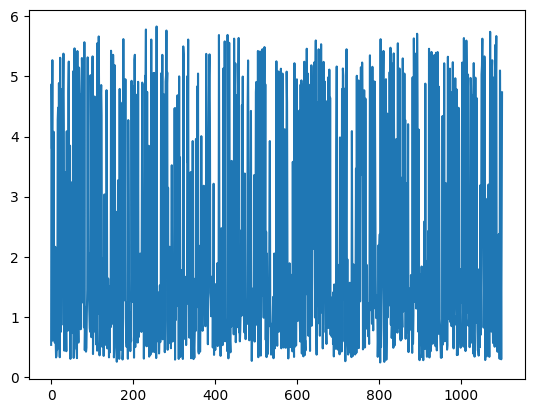

In [95]:
plt.plot(child_pred)
plt.show()